In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path_train = 'C:/Users/shume/Downloads/CAP_Data/final_train_dataset.csv'
train_data = pd.read_csv(file_path_train)

# Load the test dataset
file_path_test = 'C:/Users/shume/Downloads/CAP_Data/final_test_dataset.csv'
test_data = pd.read_csv(file_path_test)

# Display the info and first few rows of the train data
print(train_data.info())
print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252135 entries, 0 to 252134
Columns: 194 entries, SK_ID_CURR to AVG_APPLICATION_AMOUNT_y
dtypes: float64(137), int64(41), object(16)
memory usage: 373.2+ MB
None
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5

In [2]:
# Function to handle categorical variables using one-hot encoding
def encode_and_fill_data(df):
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # One-hot encode the categorical variables
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Handle missing values by filling them with the median of each column
    df_filled = df_encoded.fillna(df_encoded.median())
    
    return df_filled

# Apply the encoding and missing data handling to both train and test datasets
train_data_filled = encode_and_fill_data(train_data)
test_data_filled = encode_and_fill_data(test_data)

# Optionally, preview the first few rows to verify the transformations
print(train_data_filled.head())
print(test_data_filled.head())

   SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED  ...  FONDKAPREMONT_MODE_reg oper spec account  \
0           -637  ...                                     False   


In [3]:
# Align the test data to the training data
test_data_aligned = test_data_filled.reindex(columns=train_data_filled.columns, fill_value=0)


In [4]:
# Function to normalize features excluding the 'TARGET' column
def scale_features(df, scaler, target_col='TARGET'):
    features = df.drop(columns=[target_col]) if target_col in df.columns else df
    scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=features.index)
    
    if target_col in df.columns:
        scaled_features[target_col] = df[target_col]
    
    return scaled_features

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale features of both datasets
train_data_scaled = scale_features(train_data_filled, scaler)
test_data_scaled = scale_features(test_data_aligned, scaler)

# Display some information for verification
print(train_data_scaled.head())
print(test_data_scaled.head())

   SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0    0.000000           0.0          0.001512    0.090287     0.088736   
1    0.000003           0.0          0.002089    0.311736     0.131689   
2    0.000006           0.0          0.000358    0.022472     0.018630   
3    0.000011           0.0          0.000935    0.066837     0.108209   
4    0.000014           0.0          0.000819    0.116854     0.077664   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         0.077441                    0.256321    0.888657       0.964491   
1         0.271605                    0.045016    0.476258       0.933728   
2         0.023569                    0.134897    0.347468       0.987494   
3         0.063973                    0.107023    0.349783       0.830384   
4         0.117845                    0.392880    0.297442       0.830439   

   DAYS_REGISTRATION  ...  HOUSETYPE_MODE_specific housing  \
0           0.840893  ...     

Training Data:


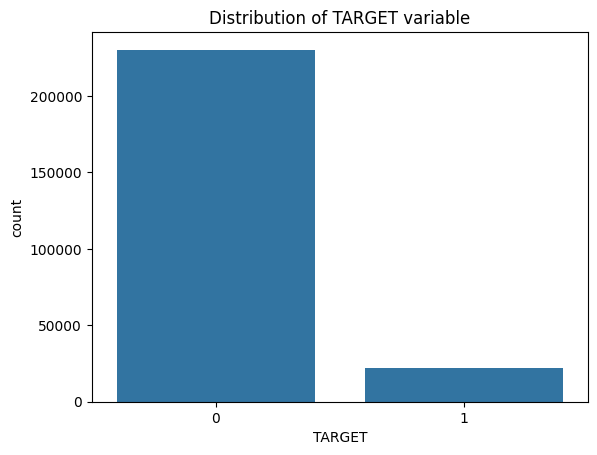

Proportion of TARGET==0: 0.9134


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the distribution of the 'TARGET' column and calculate its proportion
def plot_target_distribution_and_proportion(df, target_col='TARGET'):
    # Plot the count of each category in the 'TARGET' column
    sns.countplot(data=df, x=target_col)
    plt.title('Distribution of TARGET variable')
    plt.show()
    
    # Calculate and print the proportion of the 'TARGET' == 0 in the dataset
    proportion = df.query(f'{target_col}==0')[target_col].count() / df.shape[0]
    print(f"Proportion of TARGET==0: {proportion:.4f}")

# Assuming `train_data_scaled` and `test_data_scaled` have the 'TARGET' column,
# you can call the function for each dataset.
print("Training Data:")
plot_target_distribution_and_proportion(train_data_scaled)


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming train_data_scaled and test_data_scaled are loaded and 'TARGET' column is correctly set in train_data_scaled

# Separate features and target for training dataset
X_train = train_data_scaled.drop(columns=['TARGET'])
y_train = train_data_scaled['TARGET']

# Assuming test_data_scaled is for validation and does not have a 'TARGET' column
X_test = test_data_scaled

# Align X_train and X_test to ensure they have the same features
common_columns = list(set(X_train.columns).intersection(set(X_test.columns)))
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Create a scaler instance and scale the data using common columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply the same scaler to avoid data leakage

# Applying SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=101)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Splitting the data for further analysis if needed
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_smote, y_train_smote, test_size=0.33, random_state=42)

# Checking the value counts after SMOTE to confirm the balance
print(y_train_smote.value_counts())

TARGET
1    230301
0    230301
Name: count, dtype: int64


In [7]:
# Define and fit the Logistic Regression model
Log_model = linear_model.LogisticRegression(C=0.00001, class_weight='balanced', solver='liblinear')
Log_model.fit(X_train_smote, y_train_smote)

# Predict the labels on the validation dataset split from SMOTE data
y_pred_lr = Log_model.predict(X_test_split)

# Calculate and print evaluation metrics for Logistic Regression
metrics_lr = {
    "Accuracy": accuracy_score(y_test_split, y_pred_lr),
    "Precision": precision_score(y_test_split, y_pred_lr),
    "Recall": recall_score(y_test_split, y_pred_lr),
    "F1 Score": f1_score(y_test_split, y_pred_lr),
    "ROC AUC Score": roc_auc_score(y_test_split, Log_model.predict_proba(X_test_split)[:, 1])
}
print(f"Logistic Regression Metrics: {metrics_lr}")

Logistic Regression Metrics: {'Accuracy': 0.7110704675688656, 'Precision': 0.6759817070489424, 'Recall': 0.8097928436911488, 'F1 Score': 0.7368616571897637, 'ROC AUC Score': 0.7822742664579393}


In [8]:
# Define the Logistic Regression model
#Log_model = linear_model.LogisticRegression(C=0.00001, class_weight='balanced', solver='liblinear')
#Log_model.fit(X_train_smote, y_train_smote)

# Predict the labels on the test dataset
#y_pred_test = Log_model.predict(X_test_scaled)

# Optionally, predict the probabilities for ROC AUC calculation or other needs
y_proba_test = Log_model.predict_proba(X_test_scaled)[:, 1]

#print("Predictions on test data saved successfully.")

Predictions on test data saved successfully.


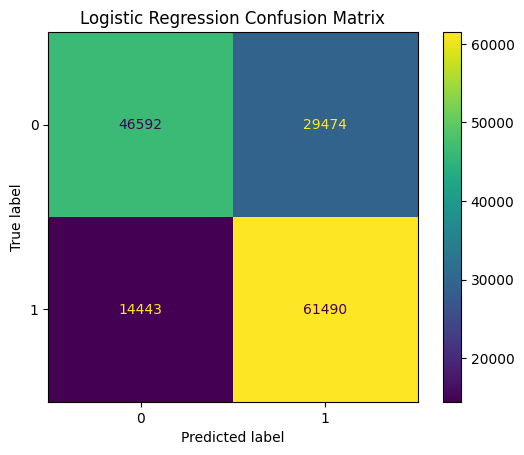

In [9]:
# Display the confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test_split, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()



In [10]:
# Define, fit, and evaluate the Random Forest model
rf = RandomForestClassifier(max_depth=10, min_samples_split=100, n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_split)  # Use split test data for evaluation

# Random Forest Metrics using split test data
metrics_rf = {
    "F1 Score": f1_score(y_test_split, y_pred_rf),
    "Recall": recall_score(y_test_split, y_pred_rf),
    "Accuracy": accuracy_score(y_test_split, y_pred_rf),
    "ROC AUC Score": roc_auc_score(y_test_split, rf.predict_proba(X_test_split)[:, 1])
}
print(f"Random Forest Metrics: {metrics_rf}")

Random Forest Metrics: {'F1 Score': 0.8979562397959518, 'Recall': 0.9017818339852238, 'Accuracy': 0.8976111684945296, 'ROC AUC Score': 0.9595335293638328}


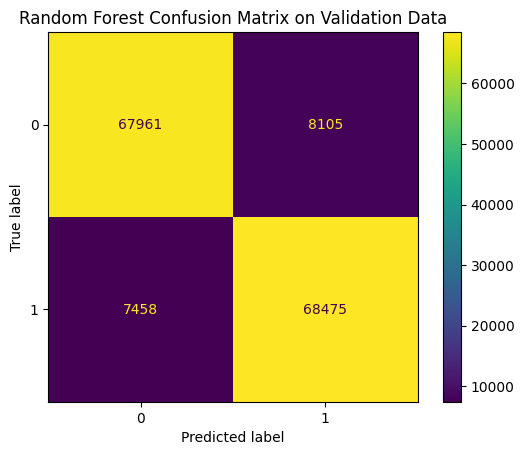

SMOTE Training Accuracy: 0.8973929770170342
SMOTE Test Accuracy: 0.8976111684945296
Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     76066
           1       0.89      0.90      0.90     75933

    accuracy                           0.90    151999
   macro avg       0.90      0.90      0.90    151999
weighted avg       0.90      0.90      0.90    151999



In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# Assuming `rf` is the RandomForestClassifier fitted on SMOTE training data (X_train_smote, y_train_smote)

# Confusion Matrix on the SMOTE test data (validation split)
cm = confusion_matrix(y_test_split, rf.predict(X_test_split))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Random Forest Confusion Matrix on Validation Data')
plt.show()

# Calculate accuracy score on SMOTE training data
train_smote_accuracy = accuracy_score(y_train_smote, rf.predict(X_train_smote))
print('SMOTE Training Accuracy:', train_smote_accuracy)

# Calculate accuracy score on SMOTE test data (validation split)
test_smote_accuracy = accuracy_score(y_test_split, rf.predict(X_test_split))
print('SMOTE Test Accuracy:', test_smote_accuracy)

# Classification report on SMOTE test data (validation split)
classification_rep = classification_report(y_test_split, rf.predict(X_test_split))
print('Classification Report on Validation Data:\n', classification_rep)

# Cross-Validation using KFold on SMOTE training data
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(rf, X_train_smote, y_train_smote, cv=kf)
print('Cross-Validation Mean Score:', cross_val_results.mean())
